In [34]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import datetime as dt

# To mock web-browser and scrap tweets
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# To consume Twitter's API
import tweepy
from tweepy import OAuthHandler 

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\sahni
[nltk_data]     tanuj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\sahni
[nltk_data]     tanuj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\sahni
[nltk_data]     tanuj\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sahni tanuj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to C:\Users\sahni
[nltk_data]     tanuj\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\sahni
[nltk_data]     tanuj\AppData\Roaming\nltk_data..

In [35]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [36]:
Tickets=pd.read_csv('all_tickets.csv')
print ('Number of Tickets are ', Tickets.shape)

Number of Tickets are  (48549, 9)


In [37]:
Tickets.dtypes

title               object
body                object
ticket_type          int64
category             int64
sub_category1        int64
sub_category2        int64
business_service     int64
urgency              int64
impact               int64
dtype: object

In [38]:
Tickets.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


# Basic Text Analysis of Tickets

In [39]:
# Finding Null Values
print(color.BOLD + color.BLUE + str(Tickets.isna().sum()))

title               712
body                  0
ticket_type           0
category              0
sub_category1         0
sub_category2         0
business_service      0
urgency               0
impact                0
dtype: int64


In [40]:
#Length of 'Tickets'
Tickets_lengths = [len(x) for x in Tickets['body']]

print (color.BOLD + color.BLUE +  'Max description length for Tickets is {}'.format(max(Tickets_lengths)))

Max description length for Tickets is 7011


In [41]:
#Destribution of lengths
pd.DataFrame(Tickets_lengths).describe(percentiles=[0.1, .25, .5, .75, .95, .99]).transpose()

,count,mean,std,min,10%,25%,50%,75%,95%,99%,max
0,48549.0,266.640178,384.651236,2.0,56.0,88.0,150.0,275.0,896.0,1900.0,7011.0


Distribution of Lenghts [Top 99%]


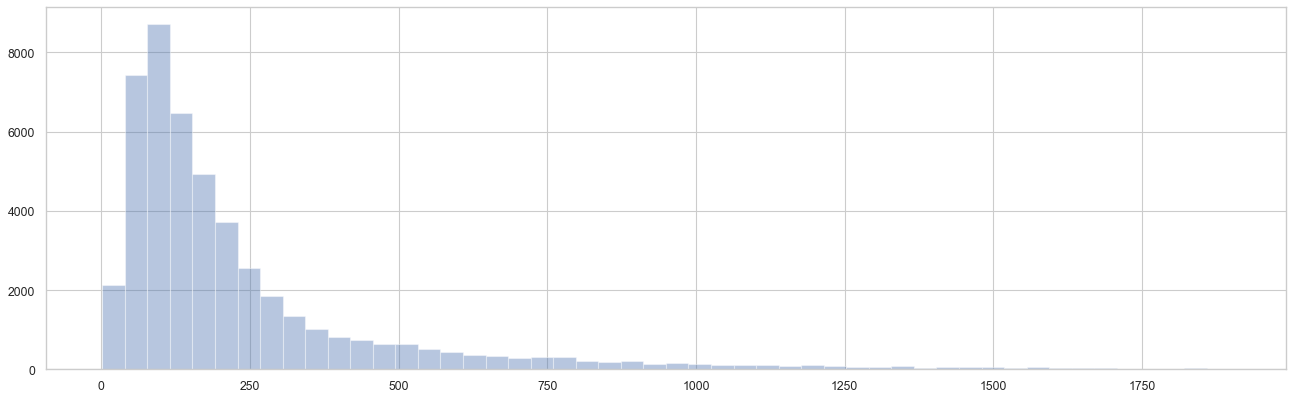

Distribution of Lenghts [All]


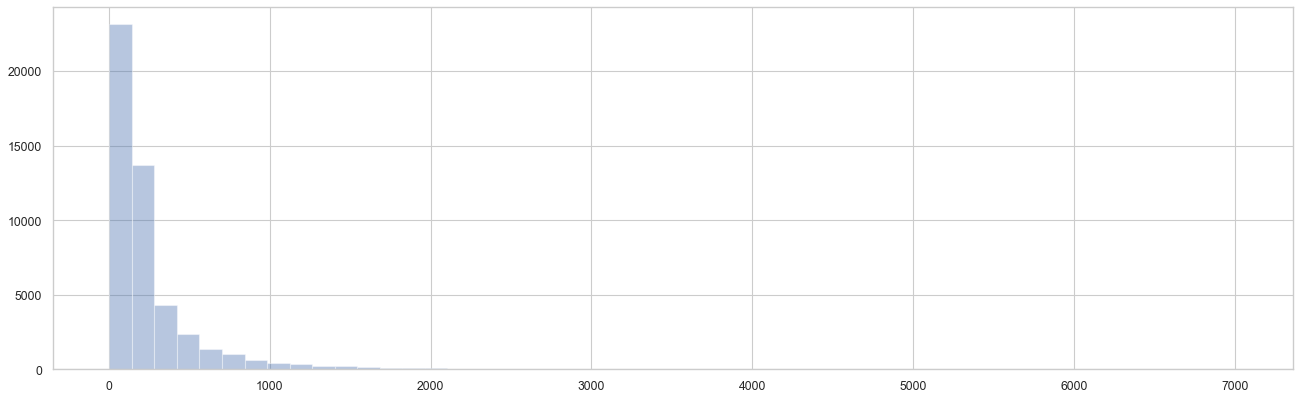

In [42]:
sns.set(style='whitegrid')
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
print(color.BOLD + color.BLUE + "Distribution of Lenghts [Top 99%]")
sns.distplot(list(filter(lambda x:x<np.percentile(Tickets_lengths,99),Tickets_lengths)), kde=False)
plt.show()
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
print(color.BOLD + color.BLUE + "Distribution of Lenghts [All]")
sns.distplot(Tickets_lengths, kde=False)
plt.show()

## Temporal frequency of Tickets¶


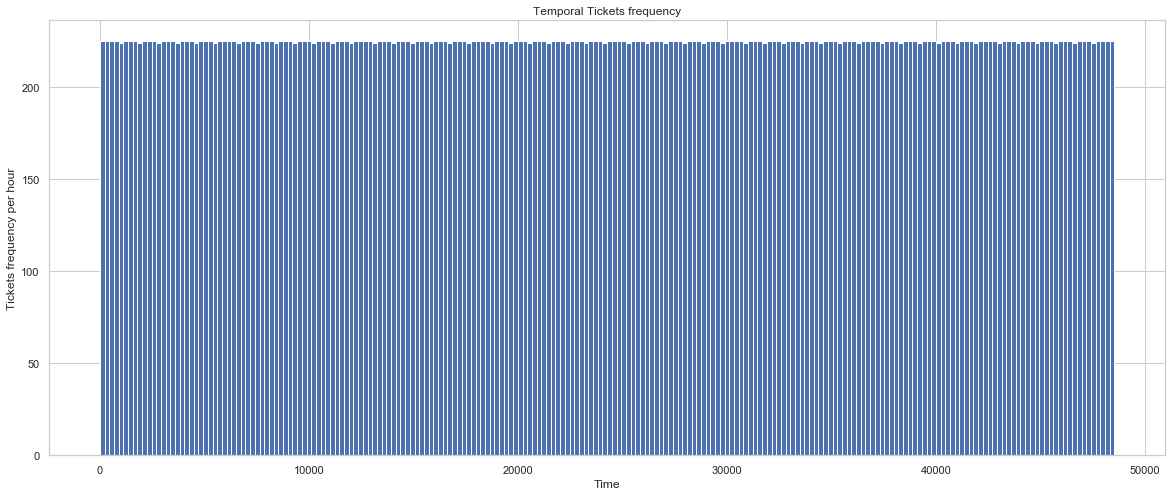

In [43]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.set(title='Temporal Tickets frequency', xlabel='Time', ylabel='Tickets frequency per hour')
plt.hist(Tickets.index, bins = 24*9, color = 'b')
plt.show()

#  Cleansing

In [44]:
# Removing URLs
Tickets['body'] = Tickets['body'].apply(lambda x: re.sub(r"https\S+", "", str(x)))

# Converting all tweets to lowercase¶
Tickets['body'] = Tickets['body'].apply(lambda x: x.lower())

#Carriage Returns & Tabs
Tickets['body'].replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=[" "," "], regex=True, inplace=True)

#Special Characters
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–","-"]
for char in spec_chars:
    Tickets['body'] = Tickets['body'].apply(lambda x:x.replace(char, ' '))

#Extra spaces
Tickets['body'].replace('\s+', ' ', regex=True, inplace=True)

In [45]:
#Remove non ASCII words
Tickets['body']=Tickets['body'].apply(lambda x:x.encode("ascii","ignore").decode())

In [109]:
#Removing StopWords
nltk.download('stopwords')
stop=set(stopwords)
stop.update(['please','know',
'high','monday','assist','st','file','requested','created','added','per','well','next','approve','care','item','back','submitted','meeting','annual'
'monday','hub','engineer','name','analyst','code','number','ticket','approved','available','head','delete','view','task','status','leaver''monday','problem','va','importance','developer','submit','users','ad','one','ask','take','note','old','guys','id','po','advise','assign','lead','id','po','today','need','test','ca','make','mailbox','required','received','phone','needed','user','receive','assigned','days','february','create','error','november', 'request', 'kindly', 'covid19', 'requesting','thank','thanks','regards','best','en','he','please','hi','please','dear','help','kindly','kind','hello','super','much','advised','pm','sent','tuesday','wednesday','thursday','friday','saturday','july','October','November','could','ext','issue','let','log','attached','change','october','date','also','information','senior','add','form','details','december','provide','leave','march','si','issues','manager','working','cannot','find','la'])

Tickets['body-tokenized']=Tickets['body'].apply(lambda x: [item for item in x if item not in stop])

[nltk_data] Downloading package stopwords to C:\Users\sahni
[nltk_data]     tanuj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [110]:
#Remove duplicates
columnsToDropDuplicates = ['body']
Tickets = Tickets.drop_duplicates(columnsToDropDuplicates)
print(Tickets.shape)

(48549, 10)


In [111]:
# !pip install contractions

In [112]:
# import contractions

# data['Long_Desc'] = data['Long_Desc'].apply(lambda v: contractions.fix(v))
# sentences = data["Long_Desc"].progress_apply(lambda x: x.split()).values
# cleaned_vocab = build_vocab(sentences)
# oov = check_coverage(cleaned_vocab,bert_vocab)

# data['Short_Desc'] = data['Short_Desc'].apply(lambda v: contractions.fix(v))
# sentences = data["Short_Desc"].progress_apply(lambda x: x.split()).values
# cleaned_vocab = build_vocab(sentences)
# oov = check_coverage(cleaned_vocab,bert_vocab)

In [113]:
# Select columns for cleaning
def cleanDataset(dataset, columnsToClean, regexList):
    for column in columnsToClean:
        for regex in regexList:
            dataset[column] = removeString(dataset[column], regex)
    return dataset


def getRegexList():
    regexList = []
    regexList += ['From:(.*)\r\n']  # from line
    # regexList += ['RITM[0-9]*'] # request id
    # regexList += ['INC[0-9]*'] # incident id
    # regexList += ['TKT[0-9]*'] # ticket id
    regexList += ['Sent:(.*)\r\n']  # sent to line
    regexList += ['Received:(.*)\r\n']  # received data line
    regexList += ['To:(.*)\r\n']  # to line
    regexList += ['CC:(.*)\r\n']  # cc line
    regexList += ['The information(.*)infection']  # footer
    regexList += ['Endava Limited is a company(.*)or omissions']  # footer
    regexList += ['The information in this email is confidential and may be legally(.*)interference if you are not the intended recipient']  # footer
    regexList += ['\[cid:(.*)]']  # images cid
    regexList += ['https?:[^\]\n\r]+']  # https & http
    regexList += ['Subject:']
    # regexList += ['[\w\d\-\_\.]+@[\w\d\-\_\.]+']  # emails
    # regexList += ['[0-9][\-0–90-9 ]+']  # phones
    # regexList += ['[0-9]']  # numbers
    # regexList += ['[^a-zA-z 0-9]+']  # anything that is not a letter
    # regexList += ['[\r\n]']  # \r\n
    # regexList += [' [a-zA-Z] ']  # single letters
    # regexList += [' [a-zA-Z][a-zA-Z] ']  # two-letter words
    # regexList += ["  "]  # double spaces

    regexList += ['^[_a-z0-9-]+(\.[_a-z0-9-]+)*@[a-z0-9-]+(\.[a-z0-9-]+)*(\.[a-z]{2,4})$']
    regexList += ['[\w\d\-\_\.]+ @ [\w\d\-\_\.]+']
    regexList += ['Subject:']
    regexList += ['[^a-zA-Z]']

    return regexList

def removeString(data, regex):
    return data.str.lower().str.replace(regex.lower(), ' ')


columnsToClean = ['body', 'title']

# Create list of regex to remove sensitive data
# Clean dataset and remove sensitive data
cleanDataset(Tickets, columnsToClean, getRegexList())

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact,body-tokenized
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4,"[h, , n, c, e, , r, e, c, r, u, e, r, , l, ..."
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4,"[c, n, , e, r, , p, l, e, e, , e, u, p, , ..."
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4,"[w, r, k, , e, x, p, e, r, e, n, c, e, , u, ..."
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4,"[r, e, q, u, e, n, g, , e, e, n, g, , h, , ..."
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4,"[r, e, , e, x, p, r, e, , , h, , k, , h, ..."
...,...,...,...,...,...,...,...,...,...,...
48544,git space for a project issues with adding users,sent tuesday july re git space for hi got righ...,0,4,21,1,39,1,3,"[e, n, , u, e, , j, u, l, , r, e, , g, , ..."
48545,error,sent july error hi guys can you help out with ...,0,4,9,41,10,2,3,"[e, n, , j, u, l, , e, r, r, r, , h, , g, ..."
48546,connection issues,sent tuesday july connection issues hello have...,0,5,32,0,32,2,3,"[e, n, , u, e, , j, u, l, , c, n, n, e, c, ..."
48547,error cube reports,sent tuesday july error hello guys have receiv...,0,4,21,41,35,1,3,"[e, n, , u, e, , j, u, l, , e, r, r, r, , ..."


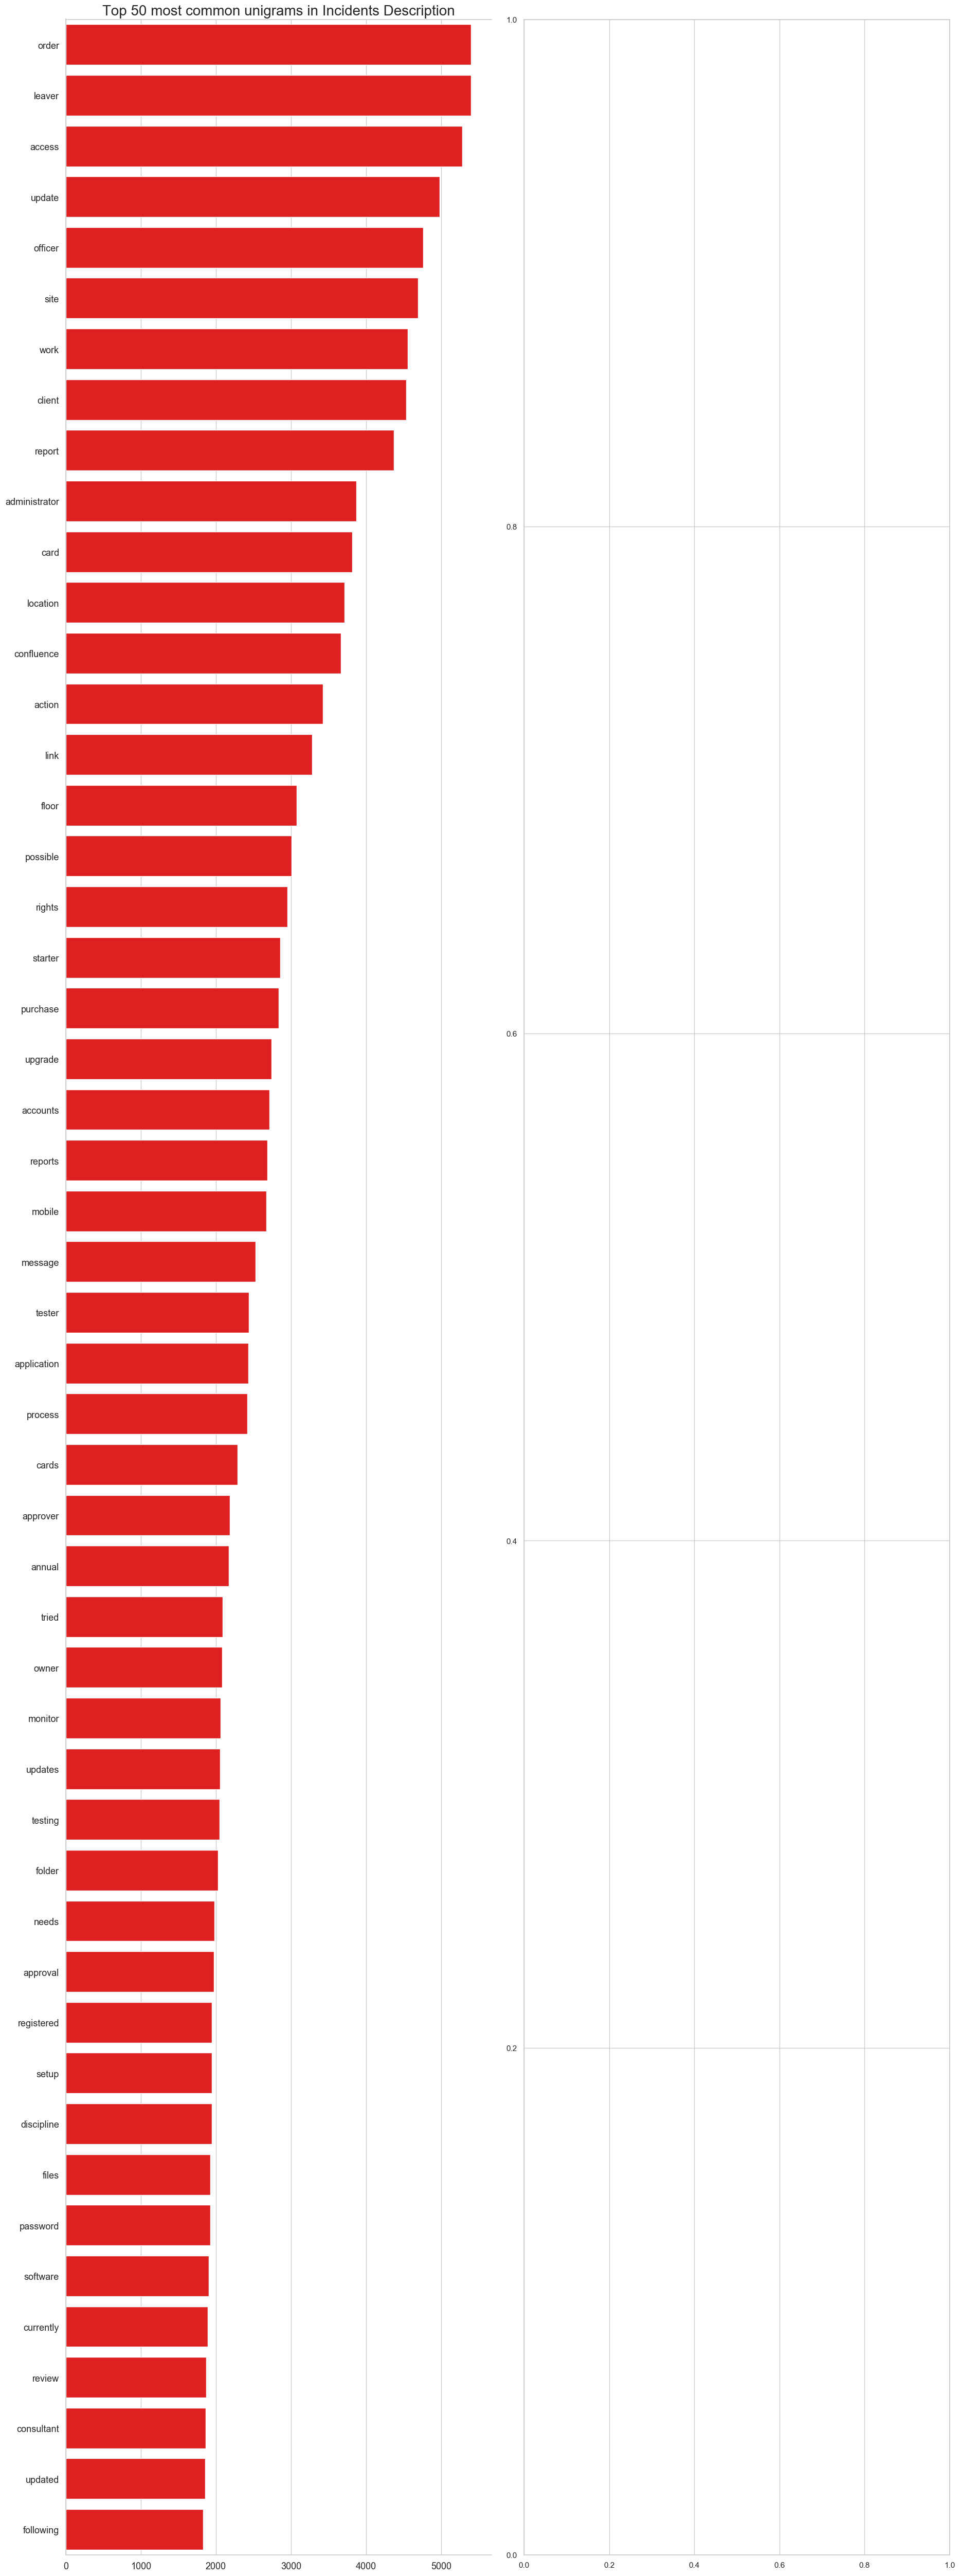

In [114]:
import collections

def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stop]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

def show_top_unigrams(column_name):
    # Unigrams
    incidents_unigrams = collections.defaultdict(int)

    for tweet in Tickets[column_name]:
        for word in generate_ngrams(tweet):
            incidents_unigrams[word] += 1

    df_incidents_unigrams = pd.DataFrame(sorted(incidents_unigrams.items(), key=lambda x: x[1])[::-1])       

    fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
    plt.tight_layout()

    N = 50

    sns.barplot(y=df_incidents_unigrams[0].values[:N], x=df_incidents_unigrams[1].values[:N], ax=axes[0], color='red')

    axes[0].spines['right'].set_visible(False)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    axes[0].tick_params(axis='x', labelsize=13)
    axes[0].tick_params(axis='y', labelsize=13)

    axes[0].set_title(f'Top {N} most common unigrams in Incidents Description', fontsize=20)

    plt.show() 
    
show_top_unigrams('body')

In [115]:
Tickets.head()
Tickets.to_csv('all_ticketsnew.csv', index=False, index_label=False)

In [116]:
print ('Data Preprocessing Ends !')

Data Preprocessing Ends !
